# Medical Appointment No-Show Prediction



## Data Wrangling

In [1]:
# Import libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from IPython.display import display

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, KFold
from time import time

%matplotlib inline

C:\Users\Xin\Anaconda3\envs\Python27\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Data Loading

df = pd.read_csv('KaggleV2-May-2016.csv')

display(df.head())

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
# Correct the typos of column names

df.rename(columns = {'Hipertension':'Hypertension', 'Handcap':'Handicap', 
                     'No-show':'No_Show'}, inplace =True)

display(df.head())

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_Show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


### Data Exploration and Data Cleaning

In [4]:
# First, let's check the total record and feature numbers in the dataset.

display(df.shape)

(110527, 14)

### There are 14 features (columns) in total included in the dataset. Some of them are unrelevant to the analysis, eg PatientID, AppointmentID. I will discard them at some point. On the other hand, I want creat some new features which may be important for the analysis.

In [5]:
# Weekday for appointment should be an important feature for patient to decide to go or not. 
# Creat 'Weekday' in the dataset

df.AppointmentDay = df.AppointmentDay.apply(np.datetime64)
df['Appt_WeekDay'] = df['AppointmentDay'].dt.weekday_name

In [6]:
df.head(6)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_Show,Appt_WeekDay
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,Friday
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,Friday
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,Friday
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,Friday
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,Friday
5,9.598513e+13,5626772,F,2016-04-27T08:36:51Z,2016-04-29,76,REPÚBLICA,0,1,0,0,0,0,No,Friday


Check the modified dataframe. Weekday of appointment is included in the dataframe.

In [7]:
# The waiting days between the scheduled date and appointment date is another important feature.
# Creat waiting days.

df.ScheduledDay = df.ScheduledDay.apply(np.datetime64)

df['Wait_Days'] = df.AppointmentDay - df.ScheduledDay

# Convert waiting days to day numbers

df['Wait_Days'] = df['Wait_Days']/np.timedelta64(1, 'D')
df['Wait_Days'] = df['Wait_Days'].apply(np.ceil)

df.head(6)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_Show,Appt_WeekDay,Wait_Days
0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,Friday,-0.0
1,5.589978e+14,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,Friday,-0.0
2,4.262962e+12,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,Friday,-0.0
3,8.679512e+11,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,Friday,-0.0
4,8.841186e+12,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,Friday,-0.0
5,9.598513e+13,5626772,F,2016-04-27 08:36:51,2016-04-29,76,REPÚBLICA,0,1,0,0,0,0,No,Friday,2.0


In [8]:
# Feature check

print 'Gender: \t%s\n' %df.Gender.unique()
print 'Age: \t%s\n' %df.Age.unique()
print 'Neighbourhood: \t%s\n' %sorted(df.Neighbourhood.unique())
print 'Waiting Days: \t%s\n' %sorted(df.Wait_Days.unique())
print 'Appointment Weekdays: \t%s\n' %sorted(df.Appt_WeekDay.unique())
print 'Scholarship: \t%s\n' %df.Scholarship.unique()
print 'Hypertension: \t%s\n' %df.Hypertension.unique()
print 'Diabetes: \t%s\n' %df.Diabetes.unique()
print 'Alcoholism: \t%s\n' %df.Alcoholism.unique()
print 'Handicap: \t%s\n' %df.Handicap.unique()
print 'SMS_received: \t%s\n' %df.SMS_received.unique()
print 'No_Show: \t%s\n' %df.No_Show.unique()

Gender: 	['F' 'M']

Age: 	[ 62  56   8  76  23  39  21  19  30  29  22  28  54  15  50  40  46   4
  13  65  45  51  32  12  61  38  79  18  63  64  85  59  55  71  49  78
  31  58  27   6   2  11   7   0   3   1  69  68  60  67  36  10  35  20
  26  34  33  16  42   5  47  17  41  44  37  24  66  77  81  70  53  75
  73  52  74  43  89  57  14   9  48  83  72  25  80  87  88  84  82  90
  94  86  91  98  92  96  93  95  97 102 115 100  99  -1]

Neighbourhood: 	['AEROPORTO', 'ANDORINHAS', 'ANT\xc3\x94NIO HON\xc3\x93RIO', 'ARIOVALDO FAVALESSA', 'BARRO VERMELHO', 'BELA VISTA', 'BENTO FERREIRA', 'BOA VISTA', 'BONFIM', 'CARATO\xc3\x8dRA', 'CENTRO', 'COMDUSA', 'CONQUISTA', 'CONSOLA\xc3\x87\xc3\x83O', 'CRUZAMENTO', 'DA PENHA', 'DE LOURDES', 'DO CABRAL', 'DO MOSCOSO', 'DO QUADRO', 'ENSEADA DO SU\xc3\x81', 'ESTRELINHA', 'FONTE GRANDE', 'FORTE S\xc3\x83O JO\xc3\x83O', 'FRADINHOS', 'GOIABEIRAS', 'GRANDE VIT\xc3\x93RIA', 'GURIGICA', 'HORTO', 'ILHA DAS CAIEIRAS', 'ILHA DE SANTA MARIA', 'ILHA DO BO

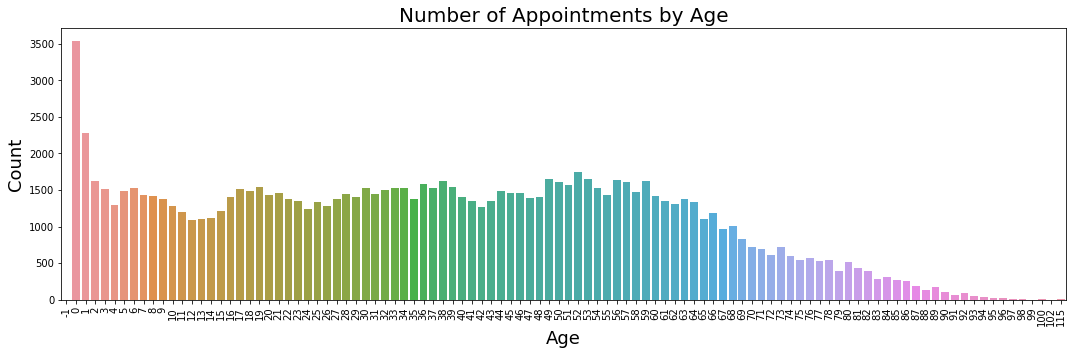

In [9]:
# Let's explore the relationship between ages and appointments.

plt.figure(figsize=(18,5))
plt.xticks(rotation=90)
ax = sns.countplot(x=df.Age)
ax.set_title("Number of Appointments by Age", fontsize = 20)
plt.xlabel("Age", fontsize = 18)
plt.ylabel("Count", fontsize = 18)
plt.show()

We need to remove the negative ages as well as ages over 100 as outliers.

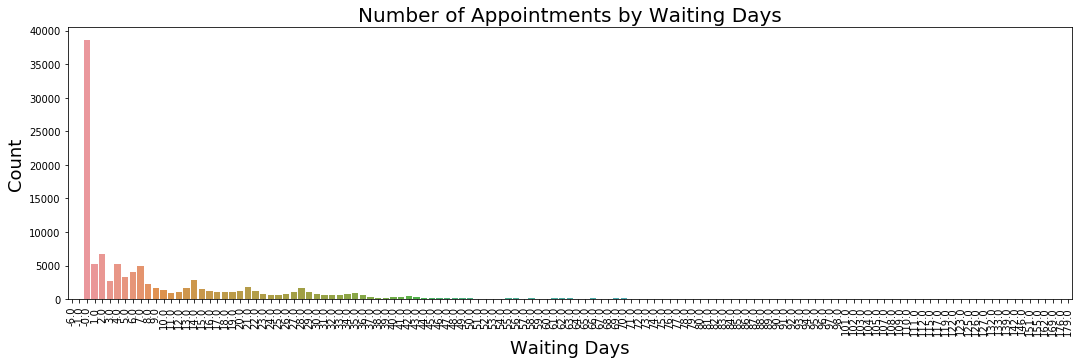

In [10]:
# Let's explore the relationship between waiting days and appointments

plt.figure(figsize=(18,5))
plt.xticks(rotation=90)
ax = sns.countplot(x=df.Wait_Days)
ax.set_title("Number of Appointments by Waiting Days", fontsize = 20)
plt.xlabel("Waiting Days", fontsize = 18)
plt.ylabel("Count", fontsize = 18)
plt.show()

We need to delete the negative waiting days which don't make sense.

In [11]:
# Remove outliers for ages and waiting days.

df = df[(df.Age >= 0) & (df.Wait_Days >= 0)]

In [12]:
# Check the ratio of no-show appointments

print 'No-show ratio: %s' %(len(df[df.No_Show == 'Yes'])*1./len(df))

No-show ratio: 0.201898281775


### Data Preparation

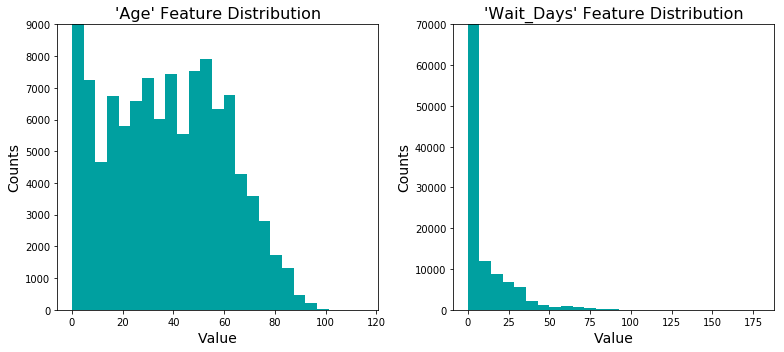

In [13]:
# Now we want to split the data into features and target label ('No_Show')

label = df['No_Show']
features_raw = df.drop(['No_Show','PatientId','AppointmentID','ScheduledDay', 'AppointmentDay'], 
                       axis = 1)

# Data Visulization of raw features
import matplotlib.pyplot as pl
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")

fig = pl.figure(figsize = (11,5));

# Visualize feature distriubtion to check if there are any skewed features.
for i, feature in enumerate(['Age','Wait_Days']):
    ax = fig.add_subplot(1, 2, i+1)
    ax.hist(features_raw[feature], bins=25, color = '#00A0A0')
    ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 16)
    ax.set_xlabel("Value", fontsize = 14)
    ax.set_ylabel("Counts", fontsize =14)
    if i==0:
        ax.set_ylim((0, 5000))
        ax.set_yticks([0, 1000, 2000, 3000, 4000, 5000,6000,7000,8000,9000])
        ax.set_yticklabels([0, 1000, 2000, 3000, 4000, 5000,6000,7000,8000,9000])
    else:
        ax.set_ylim((0, 35000))
        ax.set_yticks([0, 10000, 20000, 30000,40000,50000,60000,70000])
        ax.set_yticklabels([0, 10000, 20000, 30000,40000,50000,60000,70000])

fig.tight_layout()
fig.show()

As shown in the plots above, distributions of both 'Age' and 'Wait_Days' are skewed. In order to prevent very small values affect the performance of machine learning, we can apply a logrithmic transformation on both features which can significantly reduce the value range caused by outliers.

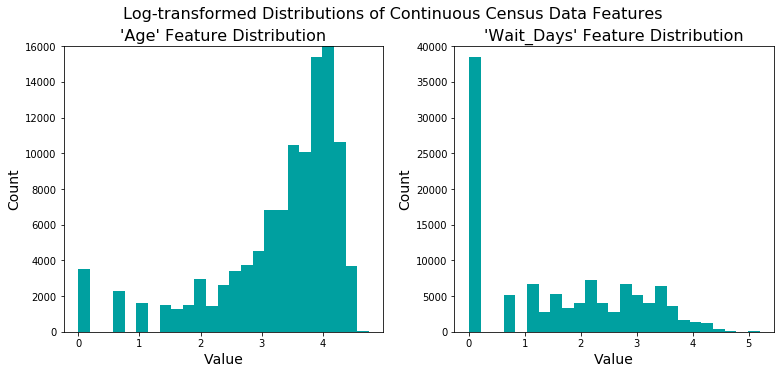

In [14]:
# Log-transform the skewed features
skewed = ['Age','Wait_Days']
features_raw[skewed] = df[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions

fig = pl.figure(figsize = (11,5));
for i, feature in enumerate(['Age','Wait_Days']):
    ax = fig.add_subplot(1, 2, i+1)
    ax.hist(features_raw[feature], bins=25, color = '#00A0A0')
    ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 16)
    ax.set_xlabel("Value", fontsize = 14)
    ax.set_ylabel("Count", fontsize = 14)
    if i==0:
        ax.set_ylim((0, 10000))
        ax.set_yticks([0, 2000, 4000, 6000, 8000, 10000, 12000,14000,16000])
        ax.set_yticklabels([0, 2000, 4000, 6000, 8000, 10000, 12000, 14000,16000])
    else:
        ax.set_ylim((0, 8000))
        ax.set_yticks([0, 5000,10000, 15000,20000,25000,30000,35000,40000])
        ax.set_yticklabels([0, 5000,10000, 15000,20000,25000,30000,35000,40000])

fig.suptitle("Log-transformed Distributions of Continuous Census Data Features", fontsize = 16, y = 1.03)
fig.tight_layout()
fig.show()

### Feature Normalization

We employ the MinMaxScaler from sklearn to normalize numerical features so that they have appropriate ranges from machine learning process.

In [15]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['Age','Wait_Days']
features_raw[numerical] = scaler.fit_transform(df[numerical])

# Show an example of a record with scaling applied
display(features_raw.head())

,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,Appt_WeekDay,Wait_Days
0,F,0.539130,JARDIM DA PENHA,0,1,0,0,0,0,Friday,0.0
1,M,0.486957,JARDIM DA PENHA,0,0,0,0,0,0,Friday,0.0
2,F,0.539130,MATA DA PRAIA,0,0,0,0,0,0,Friday,0.0
3,F,0.069565,PONTAL DE CAMBURI,0,0,0,0,0,0,Friday,0.0
4,F,0.486957,JARDIM DA PENHA,0,1,1,0,0,0,Friday,0.0


### Data Preprocessing

Convert categorical varialbes of columns into numerical variables.

In [16]:
features_raw['Gender'] = features_raw['Gender'].apply(lambda x: 1 if x == 'M' else 0)

features_raw['Handicap'] = features_raw['Handicap'].astype('str')

#One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# Encode the 'NoShow' data to numerical values
y = df['No_Show'].apply(lambda x: 1 if x == 'Yes' else 0)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# print the encoded feature names
print(encoded)

100 total features after one-hot encoding.
['Gender', 'Age', 'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'SMS_received', 'Wait_Days', 'Neighbourhood_AEROPORTO', 'Neighbourhood_ANDORINHAS', 'Neighbourhood_ANT\xc3\x94NIO HON\xc3\x93RIO', 'Neighbourhood_ARIOVALDO FAVALESSA', 'Neighbourhood_BARRO VERMELHO', 'Neighbourhood_BELA VISTA', 'Neighbourhood_BENTO FERREIRA', 'Neighbourhood_BOA VISTA', 'Neighbourhood_BONFIM', 'Neighbourhood_CARATO\xc3\x8dRA', 'Neighbourhood_CENTRO', 'Neighbourhood_COMDUSA', 'Neighbourhood_CONQUISTA', 'Neighbourhood_CONSOLA\xc3\x87\xc3\x83O', 'Neighbourhood_CRUZAMENTO', 'Neighbourhood_DA PENHA', 'Neighbourhood_DE LOURDES', 'Neighbourhood_DO CABRAL', 'Neighbourhood_DO MOSCOSO', 'Neighbourhood_DO QUADRO', 'Neighbourhood_ENSEADA DO SU\xc3\x81', 'Neighbourhood_ESTRELINHA', 'Neighbourhood_FONTE GRANDE', 'Neighbourhood_FORTE S\xc3\x83O JO\xc3\x83O', 'Neighbourhood_FRADINHOS', 'Neighbourhood_GOIABEIRAS', 'Neighbourhood_GRANDE VIT\xc3\x93RIA', 'Neighbourhood_GUR

### Data Split for Training and Testing

We will use train_test_split from sklearn to split the orginal dataset into train and test dataset with 80% of the data for training and 20% for testing.

In [17]:
# Split the 'features' and 'NoShow' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size = 0.2, random_state = 0)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 88416 samples.
Testing set has 22105 samples.


### Machine Learning Modeling

-  **Model**:
   We use random forests model to train the data

-  **Metrics**:
   We use F1-score to evaluate the model performance.

In [18]:
# Set classifier for random forest
rf_clf = RandomForestClassifier(random_state=0)

# Use classifier to train the data
rf_clf.fit(X_train, y_train)

# Implement trained classifier on test data
predictions_test = rf_clf.predict(X_test)

# Print predictions_test
score = fbeta_score(y_test, predictions_test, beta = 1)
print 'F1-score: ', score

F1-score:  0.27578078962875663


### Model Tuning

We use grid search and k-fold cross-validation training technique to optimize the benchmark model.

In [19]:
n_params = { 'n_estimators':[3,5,10,50],
              'criterion':['gini','entropy'],
              'max_depth': [3,4,5],
               'min_samples_split':[2,3,4,5],
            'min_samples_leaf':[1,2],
               'class_weight':['balanced',None]}


scorer = make_scorer(fbeta_score, beta=1)

# Perform grid search on the classifier using 'scorer' as the scoring method
gsrf = GridSearchCV(rf_clf, n_params, cv= KFold(n_splits=5,shuffle=True), scoring=scorer)

print "start"
start = time() # Get start time

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = gsrf.fit(X_train, y_train)
end = time() # Get end time
print "finish"
t_elaps = end - start
print t_elaps

# Get the estimator
best_clf = gsrf.best_estimator_

# Make predictions using the optimized model
best_predictions = best_clf.predict(X_test)
print "\n"
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 1))
print "\n"
print "The optimized model is"
print best_clf

start


C:\Users\Xin\Anaconda3\envs\Python27\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


finish
2137.33200002


Final F-score on the testing data: 0.4352


The optimized model is
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=4, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)


### Investigate Model Sensitivity

To test the robustness of the model, I used the same training model five times with different training and testing datasets to investigate the variation range of F1-score.

In [20]:
n_params = { 'n_estimators':[3,5,10,50],
              'criterion':['gini','entropy'],
              'max_depth': [3,4,5],
               'min_samples_split':[2,3,4,5],
            'min_samples_leaf':[1,2],
               'class_weight':['balanced',None]}

def fit_model(X, y):
    """ Performs grid search over parameter for a 
        random forest regressor trained on the input data [X, y]. """
 
    scorer = make_scorer(fbeta_score, beta=1)

    # Create the grid search object
    gsrf = GridSearchCV(rf_clf, n_params, cv= KFold(n_splits=5,shuffle=True), scoring=scorer)

    # Fit the grid search object to the data to compute the optimal model
    grid_fit = gsrf.fit(X_train, y_train)

    # Return the optimal model after fitting the data
    return gsrf.best_estimator_

In [21]:
def PredictTrials(X, y, fitter):
    """ Performs trials of fitting and predicting data. """

    # Store the F1 score
    f1 = []
    print "F1 score on test data for different trials:"
    for k in range(5):
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, \
            test_size = 0.2, random_state = (k+1))
        
        # Fit the data
        reg = fitter(X_train, y_train)
        
        # Make a prediction
        pred = reg.predict(X_test)
        fs = fbeta_score(y_test, pred, beta = 1)
        f1.append(fs)
        
        # Result
        print "Trial {}: {:,.4f}".format(k+1, fs)

    # Display price range
    print "\nRange in F1 score: {:,.4f}".format(max(f1) - min(f1))
    
PredictTrials(features, y, fit_model)

F1 score on test data for different trials:
Trial 1: 0.4348
Trial 2: 0.4448
Trial 3: 0.4357
Trial 4: 0.4325
Trial 5: 0.4398

Range in F1 score: 0.0123
